In [1]:
import multiprocessing
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import gensim
import logging
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=FutureWarning)
NCORES = multiprocessing.cpu_count()
logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s', level=logging.WARNING)


In [2]:


def processing_text(texto):
    """Preprocesamiento de texto

    1. Pasa a minusculas
    2. Elimina signos de puntuacion
    3. Elimina caracteres especiales
    4. Elimina numeros
    5. Divide en palabras
    Args:
        texto (str): Texto de entrada

    Returns:
        list: Lista de tokens (palabras)
    """
    texto = texto.lower()
    processed_feature = re.sub(r'\W', ' ', str(texto))
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    processed_feature = re.sub(' +', ' ', processed_feature)
    return processed_feature.strip().split(" ")


def load_folder(folder_path):
    """Carga los archivos de los libros de los autores dada una carpeta

    Args:
        folder_path (str): Carpeta donde se encuentran los libros

    Returns:
        list: Lista de documentos procesados (lista de listas)
    """
    logging.warning(f"Loading files from {folder_path}")
    files = [f"./{folder_path}/{i}" for i in os.listdir(folder_path)]
    documents = []
    for file in files:
        documents += open(file, encoding="utf-8").readlines()
    for i in range(len(documents)):
        documents[i] = processing_text(documents[i])
    logging.warning(f"Done!")
    return documents


def create_model(documents, all_docs=None, dim=100, filename=None):
    """Crea un modelo de GENSIM

    Args:
        documents (list): Lista de lista de documentos
        all_docs (list, optional): Lista de lista de todos
        los documentos del corpus. En el caso que no se defina
        se toma la misma entrada que documents. Defaults to None.
        dim (int, optional): Tamaño de entrada del embedding. Defaults to 100.
        filename (str, optional): Path para guardar el modelo. Defaults to None.

    Returns:
        word2vec: Modelo de GENSIM entrenado
    """
    all_docs = all_docs or documents
    logging.warning(f"Creating model")
    model = gensim.models.Word2Vec(
        vector_size=dim,
        window=3,
        min_count=2,
        sg=1,
        negative=10,
        workers=NCORES-2,
        seed=42,
        compute_loss=True)
    model.build_vocab(all_docs)
    model.train(documents, total_examples=len(documents), epochs=100)
    logging.warning(f"Model trained!")
    if filename:
        model.save(filename)
        logging.warning(f"Model saved to {filename}")
    return model


def create_model_from_folder(folder_path, all_docs=None, dim=100):
    """Crea el modelo word2vec de GENSIM a partir de la carpeta de un autor.

    Args:
        folder_path (str): Carpeta que contiene los libros del autor
        all_docs (list, optional): Lista de lista de documentos. Defaults to None.
        dim (int, optional): Tamaño del embedding. Defaults to 100.

    Returns:
        word2vec: modelo de GENSIM entrenado con los libros de la carpeta
    """
    try:
        os.mkdir("models")
    except Exception as e:
        pass
    docs = load_folder(folder_path)
    f = f"./models/{folder_path}_{dim}.model"
    return create_model(docs, all_docs=all_docs, filename=f, dim=dim)


def weird_plot(model, words, kind="TSNE", ndim=2):
    """Crea un grafico TSN o PCA a partir de un modelo

    Args:
        model (word2vec): Modelo de word2vec de GENSIM
        words (list): Lista de palabras a graficar
        kind (str, optional): Tipo de grafico. Puede ser TSNE o PCA. Defaults to "TSNE".
        ndim (int, optional): Dimensiones del gráfico, puede ser 2 o 3. Defaults to 2.

    """
    pca = TSNE(n_components=ndim, init="pca", random_state=42, perplexity=9)
    if kind == "PCA":
        pca = PCA(n_components=ndim)
    X = []
    colors = []
    labels = []
    for word in words:
        vector = model.wv[word]
        close_words = model.wv.most_similar([word], 5)
        colors.append("red")
        X.append(vector)
        labels.append(word)
        for cw in close_words:
            vector = model.wv[cw[0]]
            colors.append("blue")
            X.append(vector)
            labels.append(cw[0])
    X = np.array(X)
    if kind != "PCA":
        min_div = np.inf
        for i in range(1, len(X)):
            ttssne = TSNE(n_components=ndim, init="pca",
                          random_state=42, perplexity=i)
            ttssne.fit_transform(X)
            div = ttssne.kl_divergence_
            if div < min_div:
                pca = ttssne
                min_div = div

    X_pca = pca.fit_transform(X)
    if ndim == 2:
        fig = plt.figure(figsize=[10, 10])
        plt.scatter(*X_pca.T, color=colors)
        for i, label in enumerate(labels):
            plt.annotate(label, xy=X_pca[i])
        plt.show()
    elif ndim == 3:
        fig = plt.figure(figsize=[10, 10])
        ax = fig.add_subplot(projection="3d")
        ax.scatter(*X_pca.T, color=colors)
        for i, label in enumerate(labels):
            ax.text(*X_pca[i], label, None)
        plt.show()
# PCA_model = PCA(n_components=100)
# PCA_transformed_data = PCA_model.fit_transform(image_data)

# TSNE_model = TSNE(n_components=2, perplexity=30.0)
# PCA_TSNE_transformed_data = TSNE_model.fit_transform(PCA_transformed_data)

# plt.figure(figsize=[7, 4.9])

# plt.scatter(PCA_TSNE_transformed_data[:, 0], PCA_TSNE_transformed_data[:, 1],
#             c=np.array(labels).astype('int32'), s=5, cmap='tab10')

# plt.title('Lower dimensional representation of MNIST data - TSNE after PCA')
# plt.xlabel('1st dimension')
# plt.ylabel('2nd dimension')
# plt.savefig("PCA_TSNE.png")
 # En caso de que queramos probar la combinación de los dos modelos,
 # primero se reduce la dimensionalidad con PCS a 100 y luego se le hace TSNE
 # Si es muy lenta la ejecución anterior,esta al parecer lo hace mucho más rápido...


Vamos a cargar todos los documentos directamente para que el vocabulario de todos los embeddings coincida


In [3]:
# Creación de folders por clase
FOLDERS = ["DON_JULIO", "CARLITOS", "MR_POZO"]

all_docs = []
for folder in FOLDERS:
    all_docs += load_folder(folder)


2023-10-26 23:44:52,212 - WARNING - Loading files from DON_JULIO
2023-10-26 23:44:52,537 - WARNING - Done!
2023-10-26 23:44:52,538 - WARNING - Loading files from CARLITOS
2023-10-26 23:44:53,175 - WARNING - Done!
2023-10-26 23:44:53,176 - WARNING - Loading files from MR_POZO
2023-10-26 23:44:53,315 - WARNING - Done!


Se crean todos los modelos con distintos tamaños de embeddings


In [ ]:
# Creación de carpeta "models" para los experimentos con diferentes dimensionalidades
models = {}
for folder in FOLDERS:
    models[folder] = {}
    for dim in [20, 50, 50, 150, 200, 250]:
        models[folder][dim] = create_model_from_folder(
            folder, all_docs=all_docs, dim=dim)


Cargar modelos desde los archivos de guardado


In [4]:
def load_models(model_folder="models"):
    """Carga los archivos de los embeddings entrenados con GENSIM

    Args:
        model_folder (str, optional): Path a la carpeta que contiene todos los modelos. Defaults to "models".

    Returns:
        dict: Diccionario que contiene llave nombre de autor y como valor un diccionario.
        El diccionario interior contiene como llaves el tamaño de los embedings y como valor,
        el modelo word2vec de gensim que corresponde.
    """
    models = [(gensim.models.Word2Vec.load(
        f"{model_folder}/{i}"), i) for i in os.listdir(model_folder)]
    dicts = {}
    for m, mn in models:
        name = "_".join(mn.split("_")[:-1])
        if not name in dicts:
            dicts[name] = {}
        dicts[name][mn.split("_")[-1].split(".")[0]] = m
    return dicts


models = load_models()


In [5]:
autor = "CARLITOS"
dim = "200"
palabra1 = ["man", "prison", "prison", "gentleman", "light", "time"]
palabra2 = ["old", "debt", "ship", "lawyer", "christmas", "spirit"]
palabra3 = ["woman", "rich", "poverty", "blacksmith", "night", "children"]

print(autor)
model = models[autor][dim]
for p1, p2, p3 in zip(palabra1, palabra2, palabra3):
    d = model.wv[p3] + model.wv[p2]-model.wv[p1]
    lista = model.wv.most_similar(d, 10)
    for l in lista:
        if l[0] != p1 and l[0] != p2 and l[0] != p3:
            print(p1, "->", p2, ":", p3, "->", l[0])
            break


autor = "DON_JULIO"
palabra1 = ["gentleman", "world", "sea",
            "coal", "submarine", "agility", "academy"]
palabra2 = ["captain", "journey", "earth",
            "mine", "nautilus", "animal", "museum"]
palabra3 = ["indian", "london", "man",
            "cavern", "electricity", "men", "island"]
print(autor)
model = models[autor][dim]
for p1, p2, p3 in zip(palabra1, palabra2, palabra3):
    d = model.wv[p3] + model.wv[p2]-model.wv[p1]
    lista = model.wv.most_similar(d, 10)
    for l in lista:
        if l[0] != p1 and l[0] != p2 and l[0] != p3:
            print(p1, "->", p2, ":", p3, "->", l[0])
            break


autor = "MR_POZO"
palabra1 = ["creature", "body", "ghost", "space",
            "machine", "people", "military", "blood"]
palabra2 = ["captain", "human", "past", "time",
            "traveller", "martians", "war", "animal"]
palabra3 = ["people", "ape", "future", "dimensions",
            "psychologist", "woman", "earth", "space"]

print(autor)
model = models[autor][dim]
for p1, p2, p3 in zip(palabra1, palabra2, palabra3):
    d = model.wv[p3] + model.wv[p2]-model.wv[p1]
    lista = model.wv.most_similar(d, 10)
    for l in lista:
        if l[0] != p1 and l[0] != p2 and l[0] != p3:
            print(p1, "->", p2, ":", p3, "->", l[0])
            break


CARLITOS
man -> old : woman -> fashioned
prison -> debt : rich -> prodigal
prison -> ship : poverty -> honeymoon
gentleman -> lawyer : blacksmith -> sap
light -> christmas : night -> carol
time -> spirit : children -> voices
DON_JULIO
gentleman -> captain : indian -> nemo
world -> journey : london -> mont
sea -> earth : man -> exile
coal -> mine : cavern -> oftener
submarine -> nautilus : electricity -> generating
agility -> animal : men -> moneyed
academy -> museum : island -> reao
MR_POZO
creature -> captain : people -> shift
body -> human : ape -> sane
ghost -> past : future -> reverses
space -> time : dimensions -> dimension
machine -> traveller : psychologist -> volunteered
people -> martians : woman -> shrieked
military -> war : earth -> dispute
blood -> animal : space -> ebook


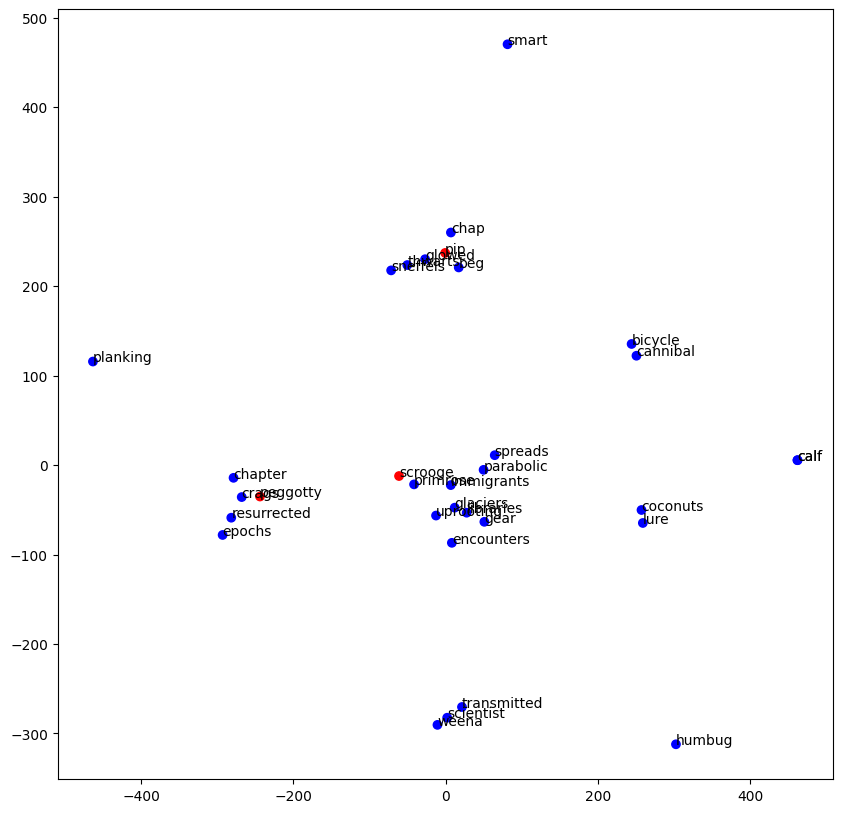

In [6]:

autor = "CARLITOS"
dim = "200"
model = models[autor][dim]
weird_plot(model, ["peggotty", "pip", "scrooge"])
